In [104]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import datetime

pd.set_option('display.max_rows', 1000)

In [2]:
!ls

Comext Open Data.ipynb
Country Distance
Instructions on how to use the bulkdownload facility.pdf
Readme.md
country_codes.csv
our_data
total_dataframe.csv


In [3]:
%%time
main_dir = 'our_data/'

path_hs = main_dir + 'transportation_hs'
all_hs = glob.glob(path_hs + "/*.dat")

list_df_hs = []

for filename in all_hs:
    df_tmp_hs = pd.read_csv(filename, index_col=None, header=0)
    list_df_hs.append(df_tmp_hs)

df_hs = pd.concat(list_df_hs, axis=0, ignore_index=True)

path_nstr = main_dir + 'transportation_nstr'
all_nstr = glob.glob(path_nstr + "/*.dat")

list_df_nstr = []

for filename in all_nstr:
    df_tmp_nstr = pd.read_csv(filename, index_col=None, header=0)
    list_df_nstr.append(df_tmp_nstr)

df_nstr = pd.concat(list_df_nstr, axis=0, ignore_index=True)

<decorator-gen-54>:2: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 44.9 s, sys: 9.53 s, total: 54.4 s
Wall time: 57.3 s


# DataFrames

## Description of the columns of df_hs DataFrame

* **DECLARANT and DECLARANT_ISO**: The Declarant (or reporting country) is the country compiling and sending data to Eurostat.
* **PARTNER and PARTNER_ISO**: The partner country is the last known country of destination for exports, the country of origin for imports from non-EU countries and the country of consignment for imports from Member States.
* **PRODUCT_HS**: file txt CN, SITC, CPA_2002, CPA_2008, CPA_2.1, BEC or by SECTION.
* **FLOW**: 1 import, 2 export.
* **TRANSPORT_MODE**: file txt in the main folder
* **PERIOD**: This code refers to the reference period.
* **VALUE_IN_EUROS**: euros already numpy.int64.
* **QUANTITY_IN_KG**: kg already numpy.int64.

In [4]:
# open the ransport mode txt file
transp_mode = pd.read_csv('our_data/TRANSPORT_MODE.txt', sep= '\t').rename({'0':'TRANSPORT_MODE', 'Unknown':'TYPE_TRANSP_MODE'}, axis=1)

# merge the dataframes
df_hs = df_hs.merge(transp_mode, on='TRANSPORT_MODE')

# create a dataframe for the flow
flow = pd.DataFrame({'FLOW':[1,2], 'TYPE_FLOW':['import', 'export']})

# merge the dataframes
df_hs = df_hs.merge(flow, on='FLOW')

# clear the period in two columns MONTH and YEAR
df_hs['MONTH'] = df_hs['PERIOD'].apply(lambda x: str(x)[4:])
df_hs['YEAR'] = df_hs['PERIOD'].apply(lambda x: str(x)[:4])

# drop the column PERIOD
df_hs.drop('PERIOD', axis=1, inplace=True)

In [5]:
df_hs[df_hs['PRODUCT_HS']=='TOTAL']; # can I delete this, right?

## Description of the columns of df_hs DataFrame

In [6]:
df_nstr = df_nstr.merge(transp_mode, on='TRANSPORT_MODE')

# merge the dataframes
df_nstr = df_nstr.merge(flow, on='FLOW')

# clear the period in two columns MONTH and YEAR
df_nstr['MONTH'] = df_nstr['PERIOD'].apply(lambda x: str(x)[4:])
df_nstr['YEAR'] = df_nstr['PERIOD'].apply(lambda x: str(x)[:4])

# drop the column PERIOD
df_nstr.drop('PERIOD', axis=1, inplace=True)

In [7]:
# container
cont = pd.read_csv('our_data/CONTAINER_MODE.txt', header=None, sep='\t').rename({0:'CONTAINER_MODE', 
                                                                                 1:'TYPE_CONTAINER_MODE'}, axis=1)

df_nstr = df_nstr.merge(cont, on='CONTAINER_MODE')

In [8]:
df_nstr.head()

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_NSTR,FLOW,TRANSPORT_MODE,CONTAINER_MODE,TRANSPORT_MEANS_NAT,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,TYPE_CONTAINER_MODE
0,1,FR,21,XC,839,2,1,0,46,10093991,35326489,Sea,export,01,2019,Not containerised
1,1,FR,21,XC,TOT,2,1,0,46,10093991,35326489,Sea,export,01,2019,Not containerised
2,1,FR,23,XL,979,2,1,0,1,925,83,Sea,export,01,2019,Not containerised
3,1,FR,23,XL,TOT,2,1,0,1,925,83,Sea,export,01,2019,Not containerised
4,1,FR,24,IS,020,2,1,0,17,17590,23450,Sea,export,01,2019,Not containerised


# Merging of the two dataframes

In [9]:
df_hs['PRODUCT_TYPE'] = 'HS'
df_nstr['PRODUCT_TYPE'] = 'NSTR'

df_hs = df_hs.rename({'PRODUCT_HS': 'PRODUCT_CODE'}, axis=1)
df_nstr = df_nstr.rename({'PRODUCT_NSTR': 'PRODUCT_CODE'}, axis=1)

df_tot = df_hs.append(df_nstr, ignore_index=True).drop(['CONTAINER_MODE', 'TRANSPORT_MEANS_NAT', 'TYPE_CONTAINER_MODE'], axis=1)

df_tot;

In [10]:
index_del = df_tot[df_tot['PRODUCT_CODE']=='TOT'].index.union(df_tot[df_tot['PRODUCT_CODE']=='TOTAL'].index)
df_tot = df_tot.drop(index_del, axis=0).reset_index(drop=True)

In [11]:
df_tot = df_tot.sort_values(by=['YEAR', 'MONTH']).reset_index(drop=True)

In [12]:
df_tot = df_tot.dropna(how='any')

## Distance

In [53]:
distance_df = pd.read_csv('Country Distance/distance.csv').sort_values(by='InputID').reset_index(drop=True)
distance_df['InputID'] = distance_df['InputID'].apply(lambda x: x.replace(' ', ''))
distance_df['TargetID'] = distance_df['TargetID'].apply(lambda x: x.replace(' ', ''))
distance_df.head()

,InputID,TargetID,Distance
0,ABW,ZWE,1.151116e+07
1,ABW,NIC,1.633202e+06
2,ABW,NER,8.373634e+06
3,ABW,NGA,8.486833e+06
4,ABW,NIU,1.148822e+07


In [14]:
ccode_df = pd.read_csv('country_codes.csv')
ccode_df.head();

In [15]:
map_dict = pd.Series(ccode_df.iloc[:,1].values,index= ccode_df.iloc[:,2]).to_dict()

In [16]:
distance_df.replace({"InputID":map_dict,"TargetID":map_dict},inplace=True)
distance_df.head()

,InputID,TargetID,Distance
0,AW,ZW,1.151116e+07
1,AW,NI,1.633202e+06
2,AW,NE,8.373634e+06
3,AW,NG,8.486833e+06
4,AW,NU,1.148822e+07


In [17]:
distance_df = distance_df.rename({'InputID':'DECLARANT_ISO', 'TargetID':'PARTNER_ISO'}, axis=1)
df_tot = df_tot.merge(distance_df, on=['DECLARANT_ISO', 'PARTNER_ISO'])

In [18]:
df_tot.to_csv('total_dataframe.csv')

# Start from Here!!! (if you have the file)

In [2]:
import os
os.chdir('C:\\Users\\Arsalan Khateeb\\Coding_Lab\\sta-py')

In [3]:
# read total dataframe

df_tot = pd.read_csv('total_dataframe.csv').drop('Unnamed: 0', axis=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# take the mean to the value of fuel
# scarse res.
# transoform the fuel in pollution
# Mi = Vmix *Qi*kH *Ci *10-6 /Ds
# type of fuel (sea, road, ...) some data 

In [5]:
# one layout for the graph
# spring layout
# export quantity and cut-off (treshold)
# local and global measure for greenness

- first step greenness and visualize and study of artcile about scc
- implementing a meaning for scc about world trande

In [6]:
df_tot['NT'] = 1

# Graph

In [7]:
df_tot;

In [8]:
# df_group = df_tot[['DECLARANT_ISO','PARTNER_ISO', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG', 'Distance']].groupby(['DECLARANT_ISO', 'PARTNER_ISO']).sum().reset_index()
# df_group = df_group.merge(distance_df, on=['DECLARANT_ISO', 'PARTNER_ISO'])

In [9]:
# graph construction
ser_nodes = df_tot['DECLARANT_ISO'].append(df_tot['PARTNER_ISO'])
nodes = ser_nodes.unique()

In [10]:
df_edges = df_tot[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance']]
tuple_edges = [tuple(r) for r in df_edges.to_numpy()]

In [11]:
# init graph
G = nx.DiGraph()

In [12]:
G.add_nodes_from(nodes)
G.add_weighted_edges_from(tuple_edges)

In [13]:
# by time

def timeTresh_graph(df, month, year, t=1, q=None):
    '''
    The treshold (t) is between 0 and 1
    q is the quantity to apply tresh:
        'euro' for euro
        'kg' for quantity in kg
    '''
    
    G = nx.DiGraph()
    
    # nodes by time
    # df_tot_time = df[(df['YEAR'] == year) & (df['MONTH'] == month)]
    df_tot_time = df
    
    # perc
    df_tot_time['VALUE_IN_EUROS'] = df_tot_time['VALUE_IN_EUROS'].apply(lambda x: x/sum(df_tot_time['VALUE_IN_EUROS']))
    df_tot_time['QUANTITY_IN_KG'] = df_tot_time['QUANTITY_IN_KG'].apply(lambda x: x/sum(df_tot_time['QUANTITY_IN_KG']))

    if q == 'euro':
        df_tot_time = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO', 'VALUE_IN_EUROS']]
        df_tot_time = df_tot_time[df_tot_time['VALUE_IN_EUROS']>=t]
    else:
        df_tot_time = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO', 'QUANTITY_IN_KG']]
        df_tot_time = df_tot_time[df_tot_time['QUANTITY_IN_KG']<=t]
    
    ser_nodes = df_tot_time['DECLARANT_ISO'].append(df_tot_time['PARTNER_ISO'])
    nodes = ser_nodes.unique()
    
    # edges by time
    df_edges = df_tot_time[['DECLARANT_ISO', 'PARTNER_ISO']]
    tuple_edges = [tuple(r) for r in df_edges.to_numpy()]
    
    G.add_nodes_from(nodes)
    G.add_edges_from(tuple_edges) # add weight 

    return G

In [14]:
# plt.figure(figsize=(70,40))
# nx.draw(G);

In [15]:
# plt.figure(figsize=(70,40))
# nx.draw(timeTresh_graph(df_group, '02', '2020', t = 0.6, q = 'euro'));

In [16]:
# perc
df_tot_filter = df_tot[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance', 'VALUE_IN_EUROS']]

In [17]:
df_tot_filter = df_tot_filter[df_tot_filter['VALUE_IN_EUROS'] >= 1700000000]
df_tot_filter;

In [18]:
plt.figure(figsize=(10,7))
Gt = nx.Graph()
ser_nodes = df_tot_filter['DECLARANT_ISO'].append(df_tot_filter['PARTNER_ISO'])
nodes = ser_nodes.unique()

# edges by time
df_edges = df_tot_filter[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance']]
tuple_edges = [tuple(r) for r in df_edges.to_numpy()]

Gt.add_nodes_from(nodes)
Gt.add_weighted_edges_from(tuple_edges)  
# nx.draw(Gt, with_labels=True, node_size=600, node_color='orange')

# edges difference between import and export

<Figure size 720x504 with 0 Axes>

In [19]:
# how to choice treshold for the values? 
# percentage or absolute value?
# 35L for 100 km

In [20]:
df_tot['TYPE_TRANSP_MODE'].unique()

# Road, Air, Sea, Rail are the most important (for us)

array(['Road', 'Air', 'Post', 'Sea', 'Rail', 'Self Propulsion',
       'Inland Waterway', 'Fixed Mechanism'], dtype=object)

# Continue Algorithm

In [21]:
# import export
# mesi/anno
# cosa? ma questo lo vediamo più tardi
# il tipo di trasporto?
# trashold euro/kg

In [22]:
# start with teh import/export
# import
df_import = df_tot[df_tot['TYPE_FLOW']=='import'].reset_index(drop=True)
# export
df_export = df_tot[df_tot['TYPE_FLOW']=='export'].reset_index(drop=True)

In [23]:
# work with the import
df_import.head()

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_CODE,FLOW,TRANSPORT_MODE,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,PRODUCT_TYPE,Distance,NT
0,1,FR,24,IS,210690,1,3,203,0,Road,import,1,2019,HS,2.439785e+06,1
1,1,FR,24,IS,220110,1,3,6826,19200,Road,import,1,2019,HS,2.439785e+06,1
2,1,FR,24,IS,392690,1,3,140,0,Road,import,1,2019,HS,2.439785e+06,1
3,1,FR,24,IS,420299,1,3,129,0,Road,import,1,2019,HS,2.439785e+06,1
4,1,FR,24,IS,610331,1,3,174,0,Road,import,1,2019,HS,2.439785e+06,1


In [24]:
len(df_import)

31251106

In [25]:
# month/year
df_import_my = df_import[(df_import['MONTH']==1) & (df_import['YEAR']==2019)].reset_index(drop=True)

In [26]:
df_import_my.head()

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_CODE,FLOW,TRANSPORT_MODE,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,PRODUCT_TYPE,Distance,NT
0,1,FR,24,IS,210690,1,3,203,0,Road,import,1,2019,HS,2.439785e+06,1
1,1,FR,24,IS,220110,1,3,6826,19200,Road,import,1,2019,HS,2.439785e+06,1
2,1,FR,24,IS,392690,1,3,140,0,Road,import,1,2019,HS,2.439785e+06,1
3,1,FR,24,IS,420299,1,3,129,0,Road,import,1,2019,HS,2.439785e+06,1
4,1,FR,24,IS,610331,1,3,174,0,Road,import,1,2019,HS,2.439785e+06,1


In [27]:
len(df_import_my)

995739

In [28]:
# type of transport (for example Road)
df_import_my_tt = df_import_my[df_import_my['TYPE_TRANSP_MODE']=='Road'].reset_index(drop=True)

In [29]:
df_import_my_tt.head()

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,PRODUCT_CODE,FLOW,TRANSPORT_MODE,VALUE_IN_EUROS,QUANTITY_IN_KG,TYPE_TRANSP_MODE,TYPE_FLOW,MONTH,YEAR,PRODUCT_TYPE,Distance,NT
0,1,FR,24,IS,210690,1,3,203,0,Road,import,1,2019,HS,2.439785e+06,1
1,1,FR,24,IS,220110,1,3,6826,19200,Road,import,1,2019,HS,2.439785e+06,1
2,1,FR,24,IS,392690,1,3,140,0,Road,import,1,2019,HS,2.439785e+06,1
3,1,FR,24,IS,420299,1,3,129,0,Road,import,1,2019,HS,2.439785e+06,1
4,1,FR,24,IS,610331,1,3,174,0,Road,import,1,2019,HS,2.439785e+06,1


In [30]:
# trashold euros
df_import_my_tt_te = df_import_my_tt[df_import_my_tt['VALUE_IN_EUROS'] >= 20000000].reset_index(drop=True)

In [31]:
len(df_import_my_tt_te)

270

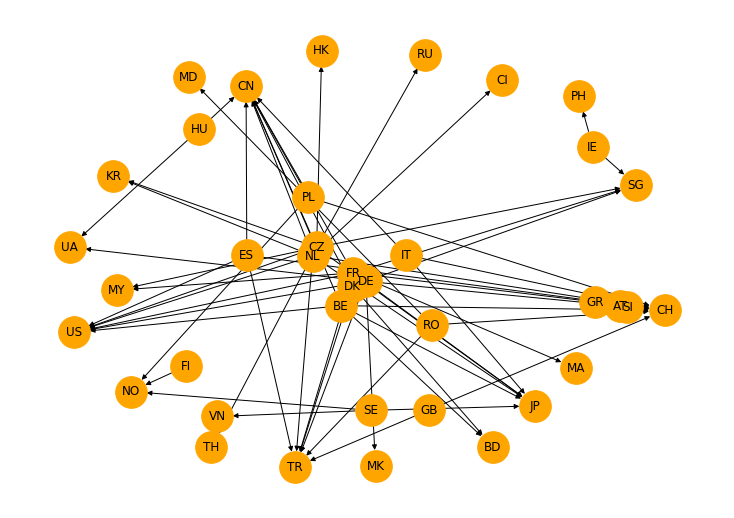

In [32]:
plt.figure(figsize=(10,7))
Gt = nx.DiGraph()
ser_nodes = df_import_my_tt_te['DECLARANT_ISO'].append(df_import_my_tt_te['PARTNER_ISO'])
nodes = ser_nodes.unique()

# edges by time
df_edges = df_import_my_tt_te[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance']]
tuple_edges = [tuple(r) for r in df_edges.to_numpy()]

Gt.add_nodes_from(nodes)
Gt.add_weighted_edges_from(tuple_edges)  
nx.draw(Gt, with_labels=True, node_size=1000, node_color='orange') 

In [33]:
df_group = df_tot[['DECLARANT_ISO','PARTNER_ISO', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG']].groupby(['DECLARANT_ISO', 'PARTNER_ISO']).sum().reset_index()

In [34]:
# important
df_tot['PRODUCT_CODE'] = df_tot['PRODUCT_CODE'].apply(lambda x: str(x))

In [35]:
df_tot['PRODUCT_CODE'].unique()

array(['210690', '220110', '392690', ..., '94MMM0', '95MMM0', '710820'],
      dtype=object)

In [36]:
df1 = df_tot[df_tot['PRODUCT_CODE']=='210690']
df2 = df1[df1['TYPE_FLOW']=='import']
df3 = df2[df2['MONTH']==1]
df4 = df3[df3['YEAR']==2019]
df5 = df4[df4['TYPE_TRANSP_MODE']=='Sea']
df6 = df5.groupby(['DECLARANT_ISO', 'PARTNER_ISO'])[['DECLARANT_ISO', 'PARTNER_ISO', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG']].sum().reset_index()
df7 = df6.sort_values(by='VALUE_IN_EUROS', ascending=False).reset_index(drop=True)

In [37]:
# 80 perc, values in euros
t = int(len(df7)*80/100)

In [38]:
df7.iloc[:t+1];

In [39]:
# main algorithm

def mainGraph(df, month = 1, year = 2019, product = None, type_flow = None, type_transport = None, type_t = None, t = 0.1, weight = 'Distance'):
    
    # product
    if product != None or product != '':
        df = df[df['PRODUCT_CODE']==product].reset_index(drop=True)
    else:
        return 'Select the product code!'
    
    # type flow
    if type_flow == 'import':
        df = df[df['TYPE_FLOW']=='import'].reset_index(drop=True)
    elif type_flow == 'export':
        df = df[df['TYPE_FLOW']=='export'].reset_index(drop=True)
    else:
        return 'Select the type of flow!'
    
    # month and year
    if month == None or year == None or month > 12 or year > 2021 or year < 2019:
        return 'Insert correctly the month and year!'
    
    if month != None and year != None:
        df = df[(df['MONTH']==month) & (df['YEAR']==year)].reset_index(drop=True)
        
    if type_transport == None:
        return 'Select the type of transport!'
    else:
        df = df[df['TYPE_TRANSP_MODE']==type_transport].reset_index(drop=True)
        
    
    minimum_e = df['VALUE_IN_EUROS'].min()
    maximum_e = df['VALUE_IN_EUROS'].max()
    minimum_k = df['QUANTITY_IN_KG'].min()
    maximum_k = df['QUANTITY_IN_KG'].max()
        
    # df['VALUE_IN_EUROS'] = df['VALUE_IN_EUROS'].apply(lambda x: (x-minimum_e)/(maximum_e-minimum_e))
    # df['QUANTITY_IN_KG'] = df['QUANTITY_IN_KG'].apply(lambda x: (x-minimum_k)/(maximum_k-minimum_k))
        
    # treshold
    # if type_t == 'e':
        # df = df[df['VALUE_IN_EUROS'] >= t].reset_index(drop=True)
    # elif type_t == 'kg':
        # df = df[df['VALUE_IN_EUROS'] >= t].reset_index(drop=True)
    # else:
        # return 'Select the type of threshold (euro or kg)!'
    
    df['Distance'] = round(df['Distance'], 3)
    
    # start changes
    df = df.groupby(['DECLARANT_ISO', 'PARTNER_ISO', 'Distance'])[['DECLARANT_ISO', 'PARTNER_ISO', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG', 'NT']].sum().reset_index()
    if type_t == 'e':
        df = df.sort_values(by='VALUE_IN_EUROS', ascending=False).reset_index(drop=True)
        # df = df[df['VALUE_IN_EUROS']>=300000]
    elif type_t == 'kg':
        df = df.sort_values(by='QUANTITY_IN_KG', ascending=False).reset_index(drop=True)
        # df = df[df['QUANTITY_IN_KG']>=6000]
    else:
        return 'Select the type of threshold (euro or kg)!'
    
    display(df)
    
    tr = int(len(df)*t/100)
    df = df.iloc[:tr+1]
    
    speed = 45 
    
    if type_transport== 'Sea':
            df['Greenness'] =  df['VALUE_IN_EUROS']/(9936.70 * df['Distance'] / (speed*1000))
    elif type_transport == 'Air':
           df['Greenness'] =  df['VALUE_IN_EUROS']/(12*df['Distance']/1000)
    elif type_transport == 'Inland Waterway':
            df['Greenness'] =  df['VALUE_IN_EUROS']/(0.12*df['Distance']/1000)
    elif type_transport == 'Road':
            df['Greenness'] = df['VALUE_IN_EUROS']/(0.25*df['Distance']/1000)
    elif type_transport == 'Rail':
            df['Greenness'] = df['VALUE_IN_EUROS']/(7.97*df['Distance']/1000)

      
    
    G = nx.DiGraph()
    # nodes
    nodes = df['DECLARANT_ISO'].append(df['PARTNER_ISO']).unique()
    # edges
    #df_edges = df[['DECLARANT_ISO', 'PARTNER_ISO', 'Distance']]
    #tuple_edges = [tuple(r) for r in df_edges.to_numpy()]
    
    # graph
    G.add_nodes_from(nodes)

    for index,row in df.iterrows():
        G.add_edge(row['DECLARANT_ISO'],row['PARTNER_ISO'],
                                             Value = row.VALUE_IN_EUROS,
                                             Quantity = row.QUANTITY_IN_KG,
                                             Distance = row.Distance,
                                             Greenness = row.Greenness)
    # G.add_weighted_edges_from(tuple_edges)
    labels = {e: str(e) for e in G.edges}
    # pos = nx.spring_layout(G, k=10000/np.sqrt(G.order()), iterations=20, scale=10) problem divided by 0
    pos = nx.spring_layout(G, iterations=20, scale=10)
    plt.figure(3, figsize=(20, 14))
    
    nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='orange')

    # Create edge labels
    labels = {e: G.edges[e][weight] for e in G.edges}

    # Draw edge labels according to node positions
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    return G
    
    # return nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='orange')

,DECLARANT_ISO,PARTNER_ISO,Distance,VALUE_IN_EUROS,QUANTITY_IN_KG,NT
0,IE,GB,413272.128,534621,2851448,1
1,LT,GE,2097179.699,482185,961632,1
2,SE,NO,261926.410,150900,853248,1
3,HR,BA,237104.349,148053,1022264,1
4,EE,RU,1356373.168,100010,404352,2
5,FR,GB,934514.567,56354,593890,1
6,DE,CH,450804.486,54876,111484,1
7,ES,GB,1563637.444,29701,246393,1
8,DE,RU,2724322.023,29580,66720,2
9,DE,TR,2425508.757,24873,54093,1


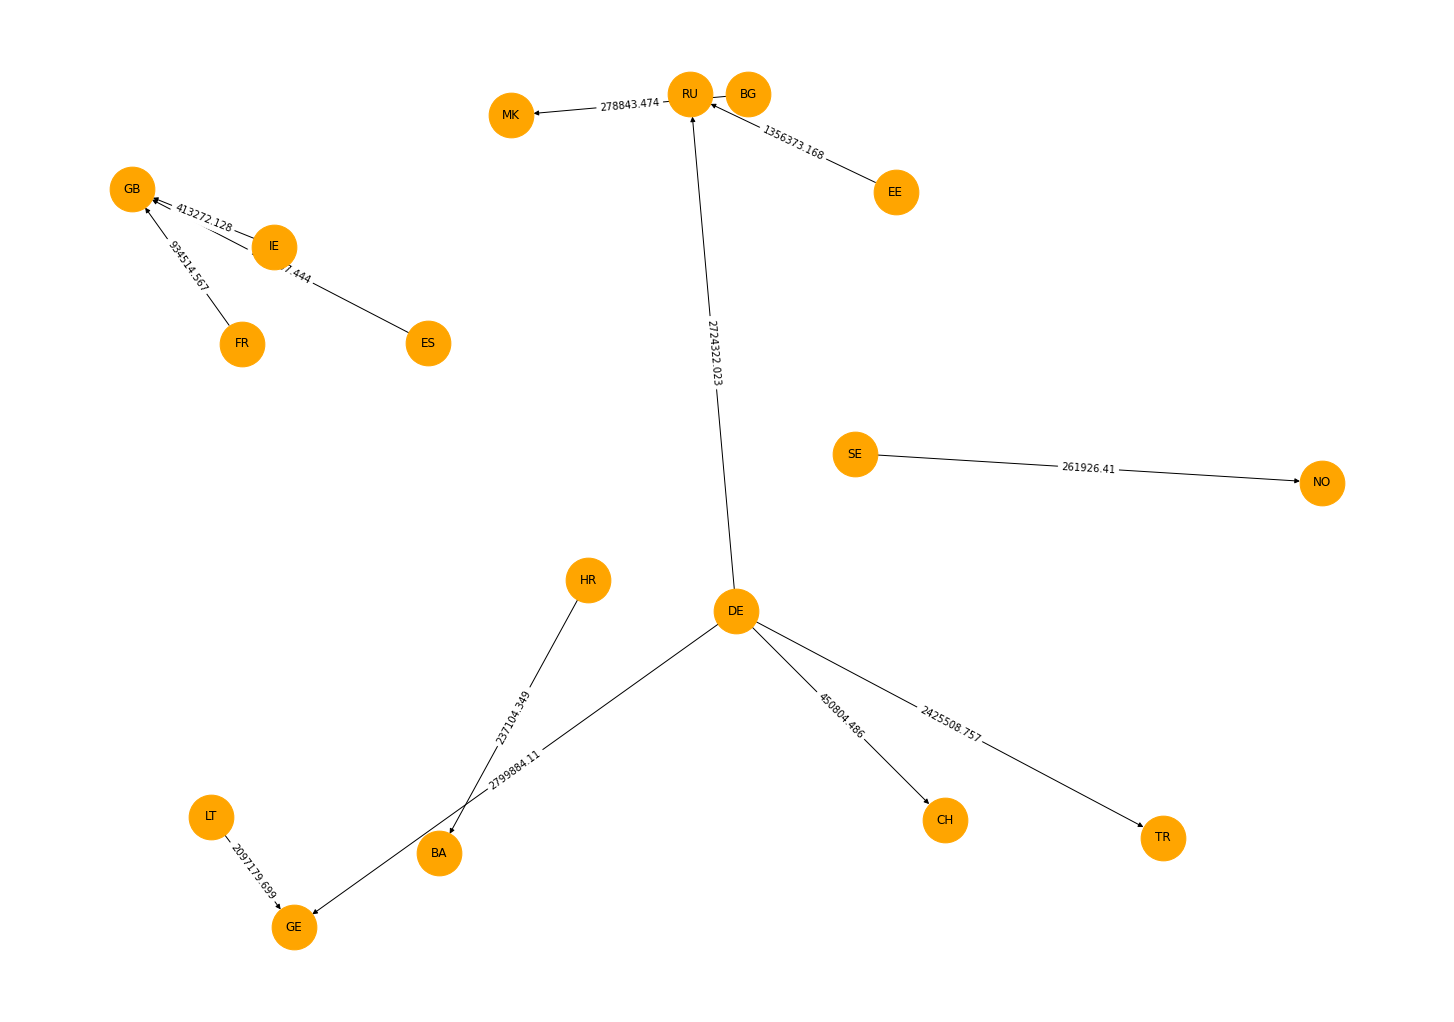

In [40]:
TradeGraph = mainGraph(df_tot, 10, 2020, '220110', 'import', 'Road', 'e', t = 20, weight = 'Distance')

In [41]:
dic_centrality = nx.degree_centrality(TradeGraph)

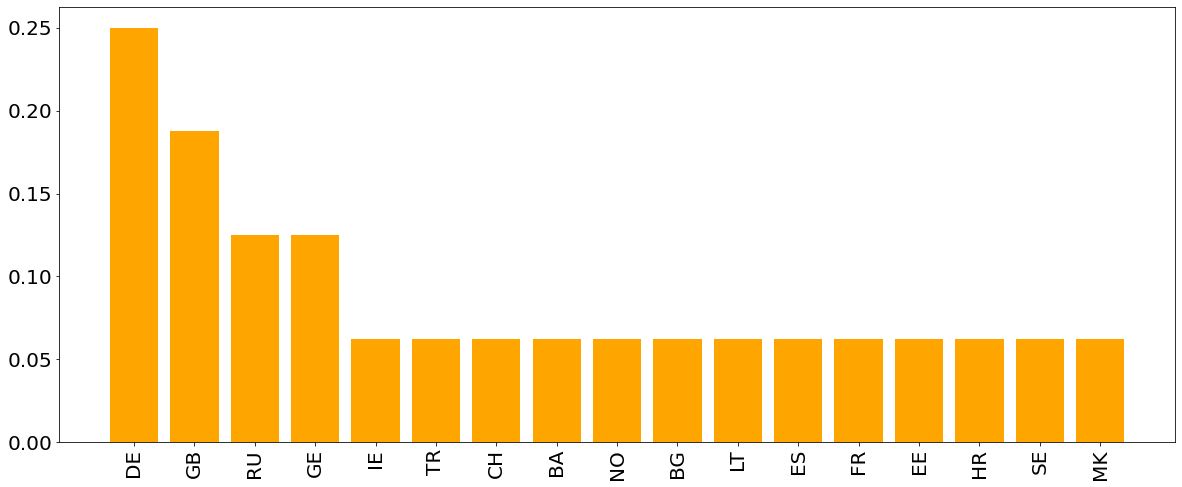

In [42]:
dic_centrality = nx.degree_centrality(TradeGraph)
df_cent = pd.DataFrame(list(dic_centrality.items()),columns = ['country','centrality']).sort_values(by='centrality', ascending=False).reset_index(drop=True)
plt.figure(figsize=(20,8))
plt.bar(df_cent['country'], height=df_cent['centrality'], color='orange')
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.show()

In [43]:
# liter per 100 km

# 0.25 l/km truck https://www.webfleet.com/en_gb/webfleet/blog/do-you-know-the-diesel-consumption-of-a-lorry-per-km/

# Sea 37.0 – 46.3 km/hr https://transportgeography.org/contents/chapter4/transportation-and-energy/fuel-consumption-containerships/

# 0.12 l / km IWT https://www.smartfreightcentre.org/pdf/GLEC-report-on-GHG-Emission-Factors-for-Inland-Waterways-Transport-SFC2018.pdf

# rail 7.97 L/ km https://www.researchgate.net/publication/321058362_Evaluation_of_emission_inventory_of_air_pollutants_from_railroad_and_air_transportation_in_Isfahan_metropolitan_in_2016/figures?lo=1

# air 12 liters per kilometer https://science.howstuffworks.com/transport/flight/modern/question192.htm

# post, self p, fixed
df_tot['TYPE_TRANSP_MODE'].unique()

array(['Road', 'Air', 'Post', 'Sea', 'Rail', 'Self Propulsion',
       'Inland Waterway', 'Fixed Mechanism'], dtype=object)

In [44]:
dict_summ = {}
for i in TradeGraph.nodes():
    summ = 0
    for j in TradeGraph[i]:
        summ = summ + TradeGraph[i][j]['Greenness'] # for each node I calculate the sum of the value of the out-edge
    dict_summ[i] = summ
        
df_green = pd.DataFrame(list(dict_summ.items()), columns=['country', 'greenness']).sort_values(by='greenness', ascending=False).reset_index(drop=True)

In [45]:
df_green

,country,greenness
0,IE,5174.517842
1,HR,2497.685102
2,SE,2304.464067
3,LT,919.682753
4,DE,603.263231
5,BG,307.412610
6,EE,294.933584
7,FR,241.211863
8,ES,75.979250
9,GB,0.000000


In [46]:
test_df = df_tot.groupby(['DECLARANT_ISO', 'PARTNER_ISO','TYPE_FLOW', 'TYPE_TRANSP_MODE','Distance'])[['DECLARANT_ISO', 'PARTNER_ISO', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG']].sum().reset_index()
test_df = test_df.loc[test_df['TYPE_TRANSP_MODE'].isin(['Road', 'Air', 'Sea', 'Rail','Inland Waterway'])].reset_index(drop=True)
test_df.head()

,DECLARANT_ISO,PARTNER_ISO,TYPE_FLOW,TYPE_TRANSP_MODE,Distance,VALUE_IN_EUROS,QUANTITY_IN_KG
0,AT,AD,export,Air,1.069266e+06,3300598,18592
1,AT,AD,export,Road,1.069266e+06,21977120,1274898
2,AT,AD,export,Sea,1.069266e+06,1699598,51770
3,AT,AD,import,Air,1.069266e+06,317388,688
4,AT,AD,import,Road,1.069266e+06,59058,6500


In [47]:
#Assuming 45km/hr speed for cargo ships
#Assuming ships consume 9936.70 l/hr 
#https://finance.yahoo.com/news/many-gallons-fuel-does-container-142703880.html
#https://transportgeography.org/contents/chapter4/transportation-and-energy/fuel-consumption-containerships/
speed = 45

In [81]:
def PlotGreenGraph(G):
    labels = {e: str(e) for e in G.edges}
    # pos = nx.spring_layout(G, k=10000/np.sqrt(G.order()), iterations=20, scale=10) problem divided by 0
    pos = nx.spring_layout(G, iterations=20, scale=10)
    plt.figure(3, figsize=(20, 14))
    
    nx.draw(G, pos=pos, with_labels=True, node_size=2000, node_color='orange')

    # Create edge labels
    labels = {e: G.edges[e]['Quantity'] for e in G.edges}

    # Draw edge labels according to node positions
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    return None

In [82]:
def GreennessGraph(df, month = 1, year = 2019, type_flow = 'export', product = None, t = 1):
    
    # product
    if product != None or product != '':
        df = df[df['PRODUCT_CODE']==product].reset_index(drop=True)
    else:
        return 'Select the product code!'
    
    # month and year
    if month == None or year == None or month > 12 or year > 2021 or year < 2019:
        return 'Insert correctly the month and year!'
    
    if month != None and year != None:
        df = df[(df['MONTH'] == month) & (df['YEAR'] == year)].reset_index(drop=True)

    df = df[df['TYPE_FLOW'] == type_flow].reset_index(drop=True) 
    
    df['Distance'] = round(df['Distance'], 3)
    
    # start changes
    df = df.groupby(['DECLARANT_ISO', 'PARTNER_ISO', 'PRODUCT_CODE','TYPE_TRANSP_MODE', 'Distance'])[['DECLARANT_ISO', 'PARTNER_ISO', 'VALUE_IN_EUROS', 'QUANTITY_IN_KG', 'NT']].sum().reset_index()
    df = df.loc[df['TYPE_TRANSP_MODE'].isin(['Road', 'Air', 'Sea', 'Rail','Inland Waterway'])].reset_index(drop=True)
    speed = 45
    
    def greeness(row):
        if row['TYPE_TRANSP_MODE'] == 'Sea':
            return row['QUANTITY_IN_KG']/(row['NT']*(9936.70 * row['Distance'] / (speed*1000)))
        elif row['TYPE_TRANSP_MODE'] == 'Air':
            return row['QUANTITY_IN_KG']/(row['NT']*(12*row['Distance']/1000))
        elif row['TYPE_TRANSP_MODE'] == 'Inland Waterway':
            return row['QUANTITY_IN_KG']/(row['NT']*(0.12*row['Distance']/1000))
        elif row['TYPE_TRANSP_MODE'] == 'Road':
            return row['QUANTITY_IN_KG']/(row['NT']*(0.25*row['Distance']/1000))
        elif row['TYPE_TRANSP_MODE'] == 'Rail':
            return row['QUANTITY_IN_KG']/(row['NT']*(7.97*row['Distance']/1000))

    df['Greenness'] = df.apply(lambda row: greeness(row), axis=1) 
    
    tr = int(len(df)*t/100)
    df = df.iloc[:tr+1]
    
    G = nx.DiGraph()
    # nodes
    nodes = df['DECLARANT_ISO'].append(df['PARTNER_ISO']).unique()
    
    # graph
    G.add_nodes_from(nodes)

    for index,row in df.iterrows():
        G.add_edge(row['DECLARANT_ISO'],row['PARTNER_ISO'],
                                             Value = row.VALUE_IN_EUROS,
                                             Quantity = row.QUANTITY_IN_KG,
                                            Distance = row.Distance,
                                            Greenness = row.Greenness)

    
    return G

In [105]:
def DFGreenGraph(G, month=None, year=None):
    dict_summ = {}
    for i in G.nodes():
        summ = 0
        for j in G[i]:
            summ += G[i][j]['Greenness'] # for each node I calculate the sum of the GREENNESS of the out-edge
        dict_summ[i] = summ
        
    dict_summQ = {}
    for i in G.nodes():
        summQ = 0
        for j in G[i]:
            summQ += G[i][j]['Quantity'] # for each node I calculate the sum of the GREENNESS of the out-edge
        dict_summQ[i] = summQ

    df_greenG = pd.DataFrame(list(dict_summ.items()), columns=['Country', 'Greenness']).sort_values(by='Greenness', ascending=False).reset_index(drop=True)
    df_greenQ = pd.DataFrame(list(dict_summQ.items()), columns=['Country', 'Quantity'])
    df_GQ = df_greenG.merge(df_greenQ, on='Country')
    df_GQ['month'] = month
    df_GQ['year'] = year
    df_GQ['date'] = datetime.datetime(year, month, 1)
    df_GQ = df_GQ[df_GQ['Greenness']>0]
    return df_GQ

In [106]:
GreenGraph = GreennessGraph(df_tot, 4, 2019, product = '210690', t = 10)

In [107]:
d = DFGreenGraph(GreenGraph, month=3, year=2021)

In [108]:
d

,Country,Greenness,Quantity,month,year,date
0,AT,10555.177772,2566730,3,2021,2021-03-01
1,BE,33.189174,3529900,3,2021,2021-03-01


In [ ]:
dict_summ = {}
for i in GreenGraph.nodes():
    summ = 0
    for j in GreenGraph[i]:
        summ += GreenGraph[i][j]['Greenness'] # for each node I calculate the sum of the GREENNESS of the out-edge
    dict_summ[i] = summ
        
df_green = pd.DataFrame(list(dict_summ.items()), columns=['Country', 'Greenness']).sort_values(by='Greenness', ascending=False).reset_index(drop=True)

In [ ]:
df_green[df_green['Greenness']>0]

In [ ]:
degrees  = dict(GreenGraph.degree())
degree_values = sorted(set(degrees.values()))
histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(GreenGraph)) for i in degree_values]
plt.bar(degree_values,histogram)
plt.xlabel('Degree')
plt.ylabel('Fractionof Nodes')
plt.show()

In [109]:
year = [2019, 2020, 2021]
month = [1,2,3,4,5,6,7,8,9,10,11,12]
df = pd.DataFrame({})
for y in year:
    if y == 2021:
        month = list(range(1, 7))   
    for m in month:
        greenG = GreennessGraph(df_tot, m, y, product = '210690', t = 10)
        greenDF = DFGreenGraph(greenG, month=m, year=y)
        df = pd.concat([df, greenDF], copy=False)
df = df.reset_index(drop=True)
print(df)

   Country     Greenness  Quantity  month  year       date
0       AT   8376.807689   2055653      1  2019 2019-01-01
1       BE     77.191074   3898485      1  2019 2019-01-01
2       AT   7972.926971   1951756      2  2019 2019-02-01
3       BG    207.073711     51238      2  2019 2019-02-01
4       BE     37.800856   3994576      2  2019 2019-02-01
5       AT   9600.459097   2486151      3  2019 2019-03-01
6       BE    187.037561   4222944      3  2019 2019-03-01
7       AT  10555.177772   2566730      4  2019 2019-04-01
8       BE     33.189174   3529900      4  2019 2019-04-01
9       AT   9350.566153   2453645      5  2019 2019-05-01
10      BE    153.898855   3704802      5  2019 2019-05-01
11      AT   9136.227546   2199920      6  2019 2019-06-01
12      BE    989.766154   4172786      6  2019 2019-06-01
13      BG    746.229023    137030      6  2019 2019-06-01
14      AT  11142.147478   2852782      7  2019 2019-07-01
15      BE   1275.756045   4274141      7  2019 2019-07-

In [113]:
import plotly.express as px
df = df[df['Country']=='AT']
fig = px.line(df, x="date", y="Greenness", animation_frame="year", animation_group="Country", hover_name="Country", markers=True)
fig["layout"]
fig.show()